#**TCS Stock Analysis Project**
##**Introduction**
This notebook analyzes Tata Consultancy Services (TCS) stock from 2020 to present using Yahoo Finance data. It covers data acquisition, cleaning, feature engineering, and visualizations to derive meaningful insights about stock performance.

In [5]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# Set plotting styles for better visuals
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [6]:
!pip install mplfinance


##**Data Acquisition and Saving Raw Data**

In [7]:
# Define Ticker and Date Range
ticker = 'TCS.NS'
start_date = '2020-01-01'
end_date = date.today()

# Download raw data (unadjusted)
df_raw = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# Save raw data for reproducibility and reference
df_raw.to_csv('TCS_Original_Raw_Data.csv', index=True)
print("Saved original raw data to TCS_Original_Raw_Data.csv")




[*********************100%***********************]  1 of 1 completed

Saved original raw data to TCS_Original_Raw_Data.csv


*Insight:*    Raw data includes splits and dividends unadjusted, useful for detailed transaction records or dividend analysis

##**Download Adjusted Data**

In [8]:
# Download adjusted data for analysis (auto_adjust=True)
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# Flatten multi-level columns if any, to avoid column access issues
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Drop rows with missing values for analysis consistency
df.dropna(inplace=True)

print(f"Successfully downloaded adjusted data for {ticker} from {start_date} to {end_date}.")

[*********************100%***********************]  1 of 1 completed

Successfully downloaded adjusted data for TCS.NS from 2020-01-01 to 2025-11-03.


*Insight:* Adjusted data accounts for dividends and splits providing a continuous price series for analysis

##**Initial Data Inspection**

In [9]:
print(f"Dataset Shape: {df.shape}")
print(df.info())
print(df.head())
print(df.describe())

Dataset Shape: (1446, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1446 entries, 2020-01-01 to 2025-10-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1446 non-null   float64
 1   High    1446 non-null   float64
 2   Low     1446 non-null   float64
 3   Open    1446 non-null   float64
 4   Volume  1446 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 67.8 KB
None
Price             Close         High          Low         Open   Volume
Date                                                                   
2020-01-01  1900.037842  1914.325646  1888.116501  1900.388381  1354908
2020-01-02  1891.315552  1910.862944  1883.908639  1910.862944  2380752
2020-01-03  1929.007568  1948.598830  1896.881632  1896.881632  4655761
2020-01-06  1928.832520  1951.184870  1917.831614  1932.820923  3023209
2020-01-07  1933.566528  1941.280111  1914.238272  1928.876831  2429317
Price        Close         High 

##**Feature Engineering: Technical Indicators**

In [10]:
#Moving Averages Calculation
#Calculate simple moving averages for trend analysis
# Moving averages: 20, 50, 200 days(Using min_periods=1 so early rows are populated instead of NaN)
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()  # Short-term trend
df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()  # Medium-term trend
df['MA200'] = df['Close'].rolling(window=200, min_periods=1).mean()# Long-term trend

# Relative Strength Index (RSI) Calculation for momentum
# Use Series aligned to df.index and avoid initial NaNs
# Wilder's smoothing
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = (-delta).clip(lower=0)
avg_gain = gain.ewm(alpha=1/14, adjust=False, min_periods=1).mean()
avg_loss = loss.ewm(alpha=1/14, adjust=False, min_periods=1).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
# If desired, cap RSI to [0, 100]
rsi = rsi.clip(0, 100)
df['RSI'] = rsi

# MACD Calculation for momentum change
# Calculate MACD and Signal Line
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

##**Visualizations and Insights**

###**Price Trend with Moving Averages**

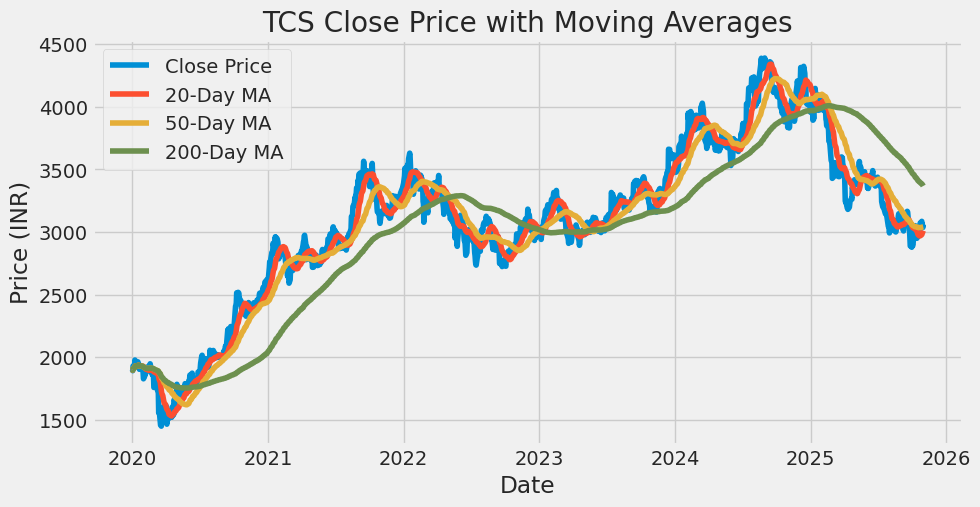

In [11]:
# Closing Price with Moving Averages
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA20'], label='20-Day MA')
plt.plot(df['MA50'], label='50-Day MA')
plt.plot(df['MA200'], label='200-Day MA')
plt.title('TCS Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

*Insight:* The general upward price trend is visible. Moving averages smooth out short-term noise and identify trend stability and potential reversals.

###**Candlestick Chart with Volume (Last 1 Year)**

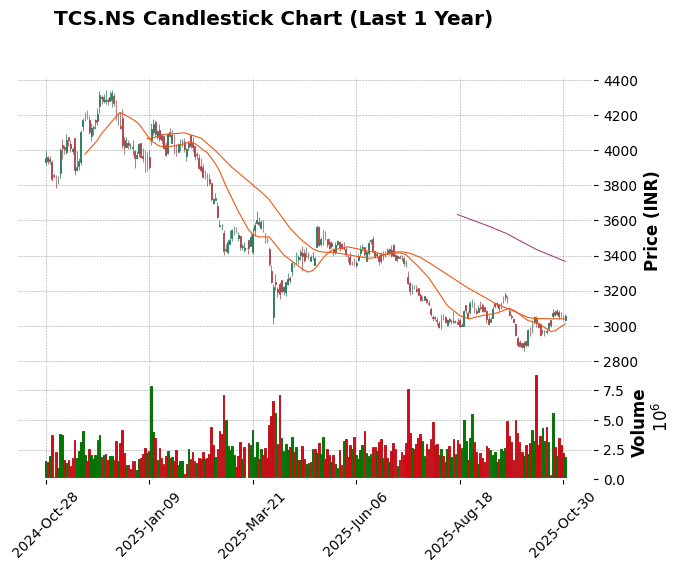

In [12]:
# Candlestick Chart for Last 1 Year with moving averages (20,50,200)
last_year_df = df.iloc[-252:]  # Approx 252 trading days ~ 1 year
mav = (20, 50, 200)
mpf.plot(last_year_df,
         type='candle',
         style='charles',
         title=f'{ticker} Candlestick Chart (Last 1 Year)',
         ylabel='Price (INR)',
         volume=True,
         mav=mav,
         ylabel_lower='Volume')

*Insight:* Price volatility, support, and resistance zones can be studied more granularly here.

###**RSI Momentum Indicator**

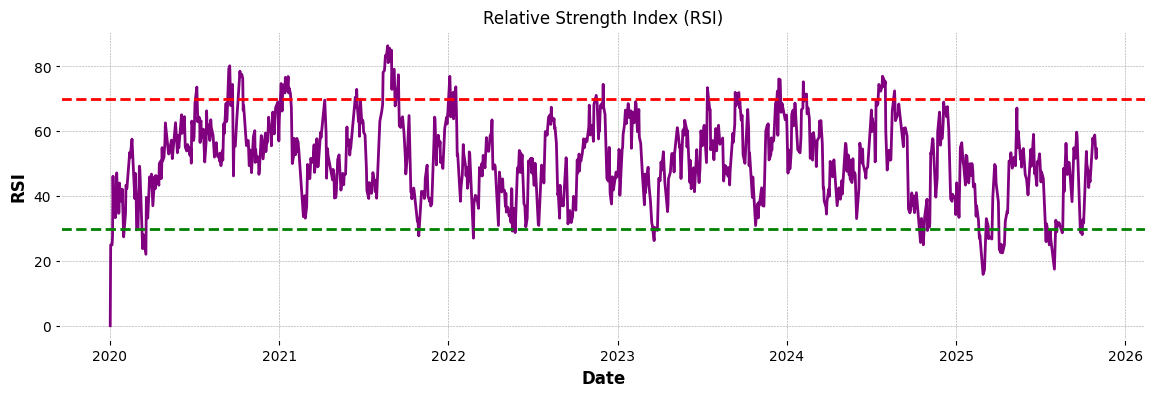

In [13]:
# RSI Plot
plt.figure(figsize=(14,4))
plt.plot(df['RSI'], color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

*Insight:* RSI values above 70 imply an overbought condition, signaling a potential pullback; below 30 indicates oversold and possible rebound

###**MACD & Signal Line**

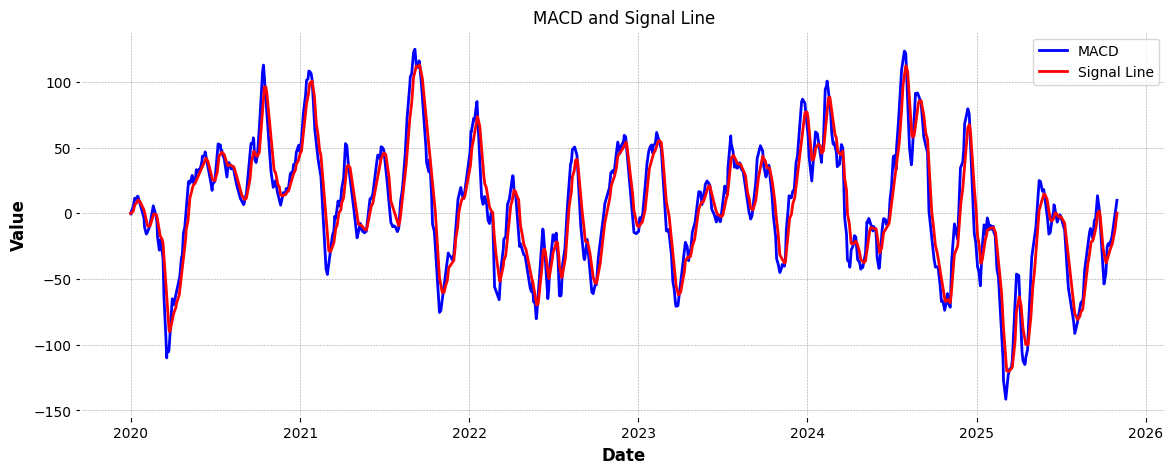

In [14]:
# MACD Plot
plt.figure(figsize=(14, 5))
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

*Insight:* MACD crossings with the signal line provide buy or sell signals based on momentum changes.

###**Distribution & Volatility of Daily Returns**

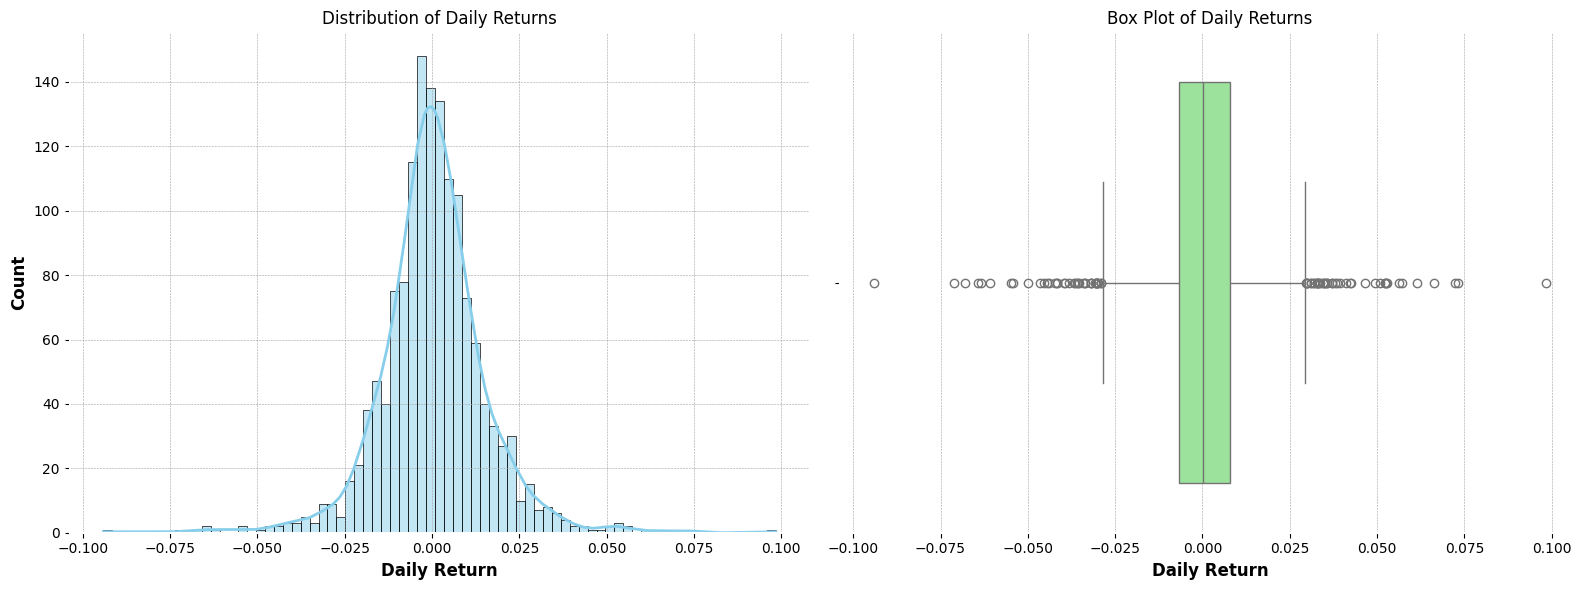

In [15]:
# Daily Returns Distribution & Volatility
df['Daily Return'] = df['Close'].pct_change()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Daily Return'].dropna(), kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Daily Returns')
sns.boxplot(x=df['Daily Return'].dropna(), ax=axes[1], color='lightgreen')
axes[1].set_title('Box Plot of Daily Returns')
plt.tight_layout()
plt.show()

*Insight:* Returns distribution is close to normal, yet the boxplot shows occasional large volatility spikes

###**Correlation Matrix**

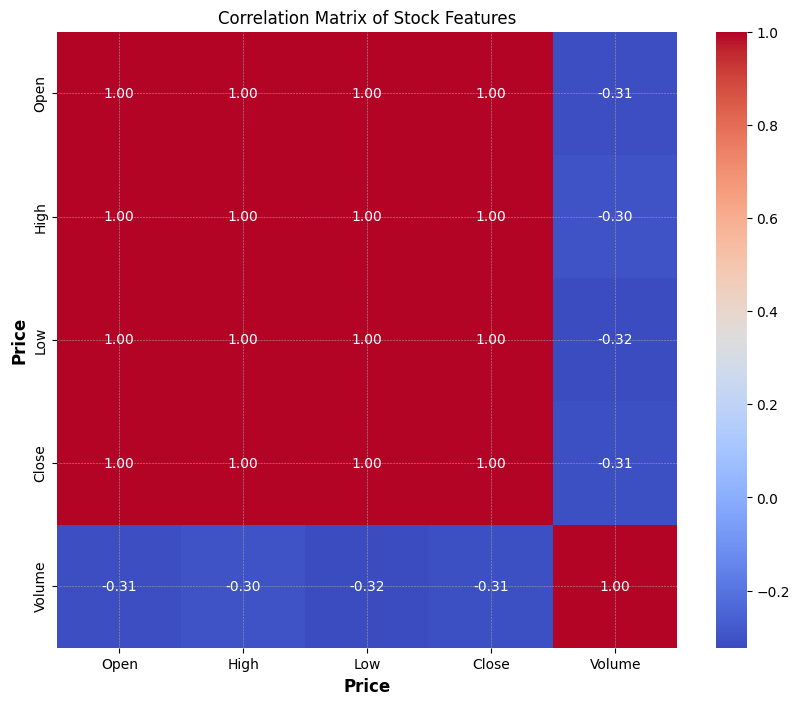

In [16]:
# Correlation Heatmap of Adjusted Prices and Volume
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Features')
plt.show()

*Insight:* Strong correlations among Open, High, Low, and Close prices; Volume shows lower correlation.

##**Yearly and Monthly Performance Insights**

###**Year-End Closing Price (Yearly)**

/tmp/ipython-input-2923033610.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_performance = df['Close'].resample('A').last()


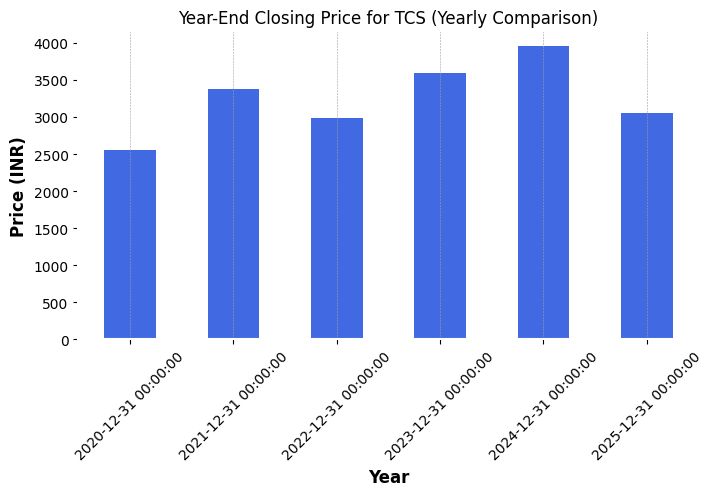

In [17]:
# Year-end closing price bar chart
yearly_performance = df['Close'].resample('A').last()
plt.figure(figsize=(8, 4))
yearly_performance.plot(kind='bar', color='royalblue')
plt.title('Year-End Closing Price for TCS (Yearly Comparison)')
plt.xlabel('Year')
plt.ylabel('Price (INR)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



*Insight:* Yearly bars illustrate overall growth trends with years of significant gains and any plateaus or declines.

###**Monthly Profit & Loss Heatmap**

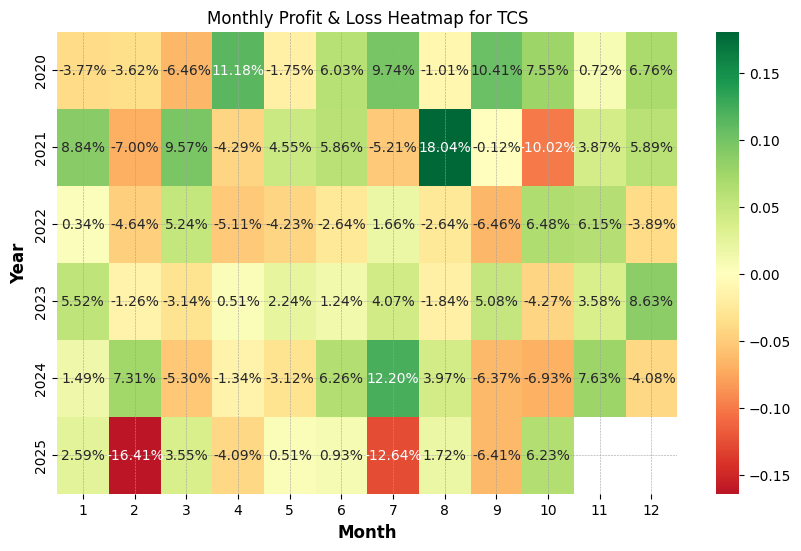

In [18]:
# Monthly profit/loss heatmap
df['Year'] = df.index.year
df['Month'] = df.index.month
monthly_returns = df.groupby(['Year', 'Month'])['Daily Return'].sum()
monthly_returns_df = monthly_returns.unstack(level=1)
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_returns_df, cmap='RdYlGn', annot=True, fmt='.2%', center=0)
plt.title('Monthly Profit & Loss Heatmap for TCS')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

*Insight:* Seasonal trends and the most/least profitable months become visually clear.

##**Export Cleaned Data to CSV**

In [19]:
df.to_csv('TCS_Adjusted_Stock_Analysis_1.csv', index=True)
print('Saved cleaned and enriched data to TCS_Adjusted_Stock_Analysis_1.csv')

Saved cleaned and enriched data to TCS_Adjusted_Stock_Analysis_1.csv


##**Summary**
- TCS stock shows steady
long-term growth with identifiable seasonal patterns.

- Technical indicators reveal momentum and possible price reversal windows.

- Volatility analysis highlights typical day-to-day fluctuation but overall stability.

- Yearly and monthly views provide performance benchmarks for investment decisions.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the cleaned price dataset
df = pd.read_csv('TCS_Adjusted_Stock_Analysis_1.csv', index_col='Date', parse_dates=True)
df = df[['Close']] # Use only Close price

# Train-Test Split
split = int(len(df)*0.8)
train = df[:split]
test = df[split:]


In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(train['Close'])
d = 1 if result[1] > 0.05 else 0

# Fit ARIMA model (choose (p=5,d,q=2) as a reasonable default)
model = ARIMA(train['Close'], order=(5,d,2))
model_fit = model.fit()
pred_arima = model_fit.forecast(steps=len(test))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [22]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Normalize data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Close']])

# Create sequences for LSTM
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_all, Y_all = create_dataset(scaled, look_back)
X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)

X_train, X_test = X_all[:split-look_back], X_all[split-look_back:]
Y_train, Y_test = Y_all[:split-look_back], Y_all[split-look_back:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)

pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1,1))


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1178
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.3151e-04
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.2356e-04
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.1028e-04
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.2281e-04
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.2611e-04
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.4376e-04
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.1810e-04
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.5128e-04
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8125e-04
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.3291e-04
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.5399e-04
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━

ARIMA MAE: 765.95, RMSE: 777419.96
LSTM MAE: 66.03, RMSE: 7408.68


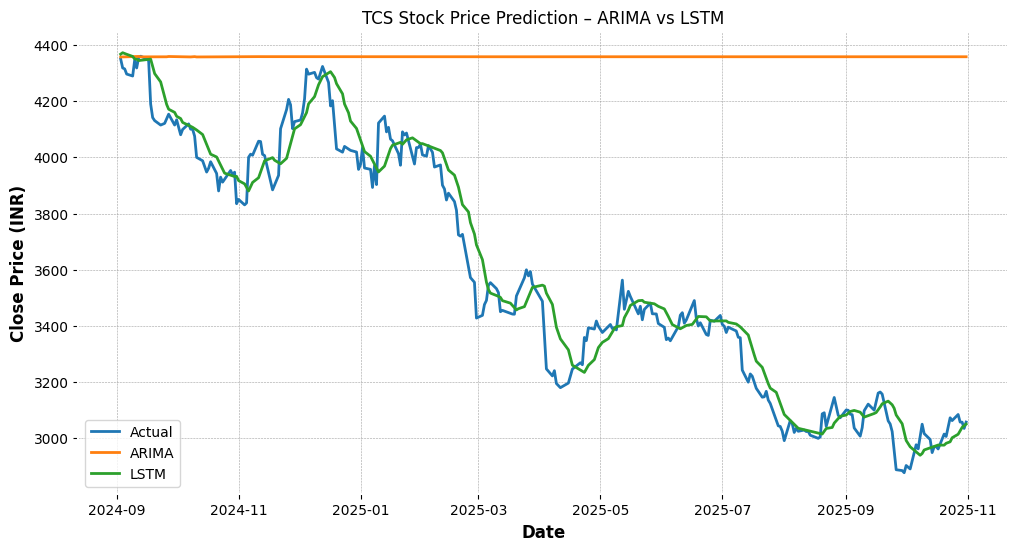

In [24]:
# ARIMA metrics
mae_arima = mean_absolute_error(test['Close'], pred_arima)
rmse_arima = mean_squared_error(test['Close'], pred_arima)

# LSTM metrics
mae_lstm = mean_absolute_error(Y_test_actual, pred_lstm)
rmse_lstm = mean_squared_error(Y_test_actual, pred_lstm)

print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")

# Plot comparison
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, pred_arima, label='ARIMA')
plt.plot(test.index, pred_lstm.flatten(), label='LSTM')
plt.title('TCS Stock Price Prediction – ARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.show()
